# Problem statement: 

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### 1. Importing Skin Cancer Data

#### 1.1 Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
#using the data by mounting the google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


We have image datast divided into two groups viz. Train and Test. The dataset comprises of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images

data_dir_train = pathlib.Path("gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [ ]:
#check out the no. of images in Train and Test sets

image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


#### 1.2 Load using keras.preprocessing

In [ ]:
# Defining parameters for the loader
batch_size = 32
img_height = 180
img_width = 180

Here we are using  80% of the images for training, and 20% for validation, from the Training directory.

In [ ]:
## Writing the train dataset 

train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=batch_size, image_size=(img_height,img_width), seed=123, validation_split=0.2, subset='training')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
## Writing the  validation dataset 

val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=batch_size, image_size=(img_height,img_width), seed=123, validation_split=0.2, subset='validation')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# Listing out all the classes of skin cancer and store them in a list. 

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### 2. Visualize the data
#### 2.1 Visualizing one instance of all the nine classes present in the dataset

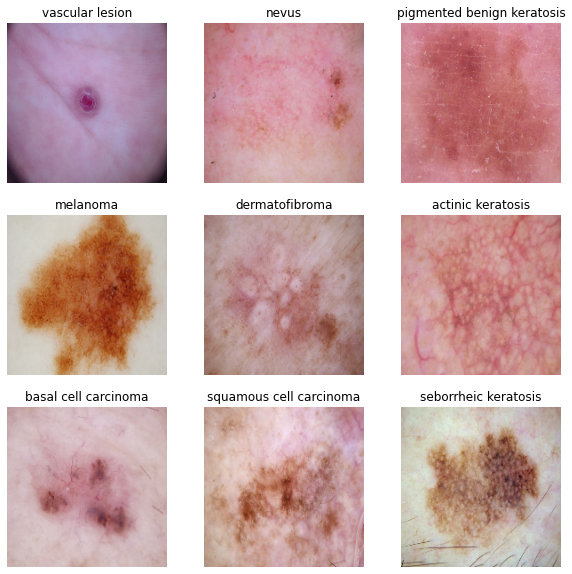

In [ ]:
plt.figure(figsize=(10, 10))
class_names_set = set(class_names)
j=0
while len(class_names_set)!=0:
    for images, labels in train_ds.take(1):   
        for i in range(len(images)): 
            if class_names[labels[i].numpy()] in class_names_set: 
                class_names_set.remove(class_names[labels[i].numpy()])
                ax = plt.subplot(3, 3, j + 1)
                plt.title(class_names[labels[i].numpy()])
                plt.imshow(images[i].numpy().astype("uint8"))
                plt.axis('off')
                j+=1
              

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Now that we are done with importing, bifurcating and visualizing the datset, let's move towards model building. Here we will use Convolutional Neural Network for extracting the different features of image dataset. Now since the images are more detailed, we will use high number of kernels in each `CNN` layers, to catch those details. Further, the landscape area does not seem of much importance for this image clasification task and hence we will use less no. of `CNN` layers.


### 3. Model building:1

#### 3.1 Creating the Model-1


In [ ]:
num_classes = 9

model = Sequential([
layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
layers.Conv2D(16, kernel_size=(3,3), padding='same', activation='relu'),
layers.MaxPooling2D(),
layers.Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'),
layers.MaxPooling2D(),
layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'),
layers.MaxPooling2D(),
layers.Flatten(),
layers.Dense(128, activation='relu'),
layers.Dense(num_classes, activation='softmax')
])

#### 3.2 Compiling the Model-1

Here we will use,
1. `Adam optimiser` due to it's easy to implement, computational efficiency, and less memory space requirement.
2. `CategoricalCrossentropy` as it computes the crossentropy loss between the labels and predictions.
3. `Accuracy` calculates how often predictions equal labels.

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

From the above model summary, we note that we have total `3,989,801` Trainable params and `0` Non-trainable params. Let's now train our model and see it's performance on our dataset.

####  3.3 Training the Model-1

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 1349s 5s/step - loss: 2.1198 - accuracy: 0.1825 - val_loss: 1.7049 - val_accuracy: 0.3960
Epoch 2/20
56/56 [==============================] - 2s 41ms/step - loss: 1.6232 - accuracy: 0.4102 - val_loss: 1.4699 - val_accuracy: 0.5011
Epoch 3/20
56/56 [==============================] - 2s 41ms/step - loss: 1.3985 - accuracy: 0.5121 - val_loss: 1.4202 - val_accuracy: 0.5190
Epoch 4/20
56/56 [==============================] - 2s 40ms/step - loss: 1.2990 - accuracy: 0.5543 - val_loss: 1.4611 - val_accuracy: 0.4899
Epoch 5/20
56/56 [==============================] - 2s 40ms/step - loss: 1.1652 - accuracy: 0.6006 - val_loss: 1.4708 - val_accuracy: 0.4855
Epoch 6/20
56/56 [==============================] - 2s 40ms/step - loss: 1.1792 - accuracy: 0.5784 - val_loss: 1.3746 - val_accuracy: 0.5302
Epoch 7/20
56/56 [==============================] - 2s 41ms/step - loss: 1.0614 - accuracy: 0.6196 - val_loss: 1.3853 - val_accuracy: 0.5213
Epoch 8/20
5

#### 3.4 Visualizing training results of Model-1

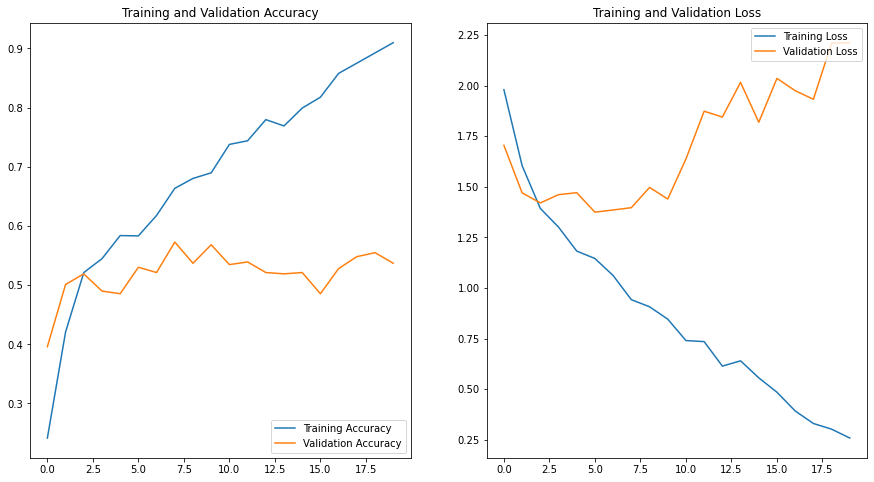

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1. From the above Accuracy vs Epoch plot, we notice that Training Accuracy is continously rising while the Validation Accuracy is getting flattened out after 4th epoch.
2. Further from Loss vs Epoch plot, we note that Training Loss is getting decresed while the corresponding Validation loss is reaching to its lower peak at around 4th epoch and rising again.

The above two points are the clear indication of overfiting of the CNN model on our dataset. To tackle the issue of overfitting, we will use Data Augmentation. Let's use the RandomRotation layer of keras and see whether we benefit from the data augmentation. 

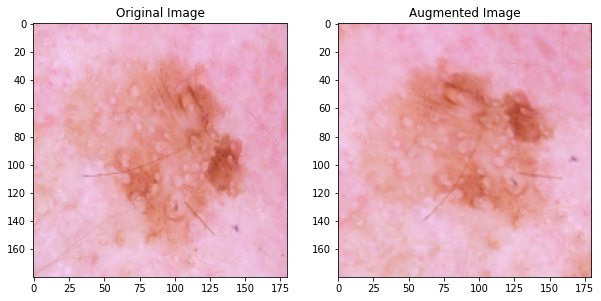

In [ ]:
# Let's visualize how RandomRotation augmentation strategy works for one instance of training image.

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.experimental.preprocessing.RandomRotation(0.2)
])

# Add the image to a batch
images, labels = next(iter(train_ds.take(1)))
for image in images:
  plt.figure(figsize=(10, 10))
  ax = plt.subplot(1, 2, 1)
  plt.imshow(image.numpy().astype("uint8"))
  plt.title("Original Image")
  image = tf.expand_dims(image, 0)
  aug = data_augmentation(image)
  ax = plt.subplot(1, 2, 2)
  plt.imshow(aug[0])   
  plt.title("Augmented Image")
  break



From the above, we see that we are able to create the additional, augmented dataset with the help of keras package. Let's build upon the same and create another model with `Rescaling` layer provided by keras package.

### 4.Model building:2 

#### 4.1 Creating the Model-2

In [ ]:
### Your code goes here

num_classes = 9

model2 = Sequential([
layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
layers.experimental.preprocessing.RandomRotation(0.2),                       #using the RandomRotation layer to augment the data
layers.Conv2D(16, kernel_size=(3,3), padding='same', activation='relu'),
layers.MaxPooling2D(),
layers.Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'),
layers.MaxPooling2D(),
layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'),
layers.MaxPooling2D(),
layers.Flatten(),
layers.Dense(128, activation='relu'),
layers.Dense(num_classes, activation='softmax')
])

#### 4.2 Compiling the Model-2

In [ ]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
random_rotation_1 (RandomRot (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

#### 4.3 Training the Model-2

In [ ]:
epochs = 20
history = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 3s 47ms/step - loss: 2.3167 - accuracy: 0.2157 - val_loss: 1.8665 - val_accuracy: 0.2975
Epoch 2/20
56/56 [==============================] - 2s 42ms/step - loss: 1.7449 - accuracy: 0.3632 - val_loss: 1.6029 - val_accuracy: 0.4452
Epoch 3/20
56/56 [==============================] - 2s 42ms/step - loss: 1.5651 - accuracy: 0.4461 - val_loss: 1.4628 - val_accuracy: 0.5302
Epoch 4/20
56/56 [==============================] - 2s 43ms/step - loss: 1.5151 - accuracy: 0.4650 - val_loss: 1.3684 - val_accuracy: 0.5235
Epoch 5/20
56/56 [==============================] - 2s 43ms/step - loss: 1.4172 - accuracy: 0.4695 - val_loss: 1.3416 - val_accuracy: 0.5302
Epoch 6/20
56/56 [==============================] - 2s 43ms/step - loss: 1.3463 - accuracy: 0.5157 - val_loss: 1.3114 - val_accuracy: 0.5391
Epoch 7/20
56/56 [==============================] - 2s 43ms/step - loss: 1.3301 - accuracy: 0.5387 - val_loss: 1.2969 - val_accuracy: 0.5436
Epoch 8/20
56

#### 4.4 Visualizing training results of Model-2

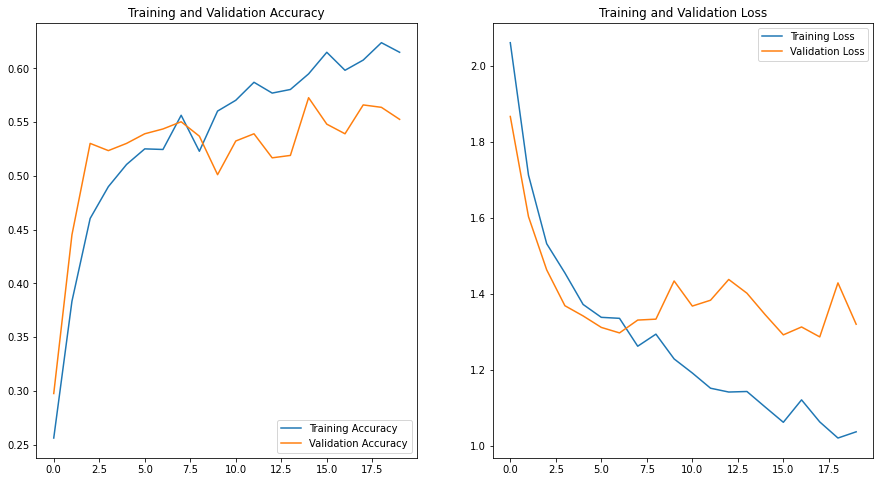

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

From the above, we note the following:
1. There is less gap between training and validation accuracy as well as loss through out all the epoches. The same indicates reduction in overfitting.
2. However, we have got degradation in the Accuracy and Loss, after the application of data augmentation.
3. So we can say that we have been able to reduce the `Variance` with the application of data augmentation but we have high `Bias`  now.

### 5. Data distribution check

Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data. Let's find the distribution of classes in the original training dataset.

In [ ]:
from glob import glob

path_list_original = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list_original = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]

dataframe_dict_original = dict(zip(path_list_original, lesion_list_original))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df['Label'].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

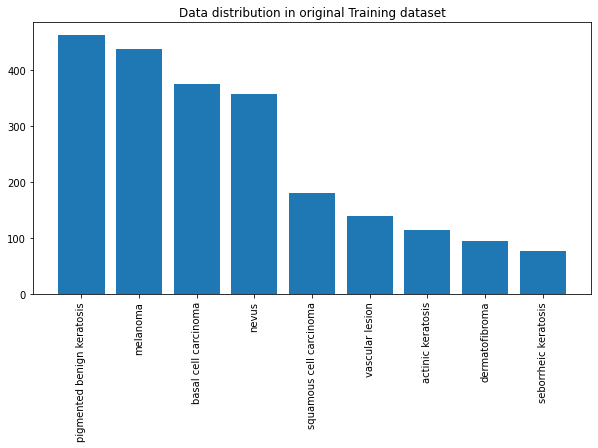

In [ ]:
plt.figure(figsize=(10,5))
plt.bar(x=original_df['Label'].value_counts().index, height=original_df['Label'].value_counts().values)
plt.xticks(rotation='vertical')
plt.title('Data distribution in original Training dataset')
plt.show()

1. From the above, we note that `seborrheic keratosis` has the least number of samples i.e. 77 in the original train dataset.

2. From the above, we note that `pigmented benign keratosis` has the highest number of samples i.e. 462 in original train dataset.


#### 5.1 Class imbalance rectification

We note that there is class imbalance in the dataset. It might be possible that the same is resulting into high `Bias` in our Model-2. Let's try to rectify the same with Augmentor package of python. Here we will add more samples across all classes so that none of the classes have very few samples.

In [ ]:
pip install Augmentor

In [ ]:
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline("gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train" + "/"+i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)           # We are adding 500 samples per class to make sure that none of the classes are sparse.

Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBED8C2BB90>: 100%|██████████| 500/500 [00:22<00:00, 22.43 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FBEDA06A310>: 100%|██████████| 500/500 [00:22<00:00, 22.08 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBE8FD12C50>: 100%|██████████| 500/500 [00:22<00:00, 22.03 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FBED8CBCA90>: 100%|██████████| 500/500 [01:45<00:00,  4.72 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FBED8C2BF90>:   0%|          | 1/500 [00:00<01:12,  6.85 Samples/s]

Initialised with 357 image(s) found.
Output directory set to gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1028x753 at 0x7FBED8B5E290>: 100%|██████████| 500/500 [01:32<00:00,  5.38 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 462 image(s) found.
Output directory set to gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBE26AAF990>: 100%|██████████| 500/500 [00:23<00:00, 21.18 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FBEDA113450>: 100%|██████████| 500/500 [00:49<00:00, 10.07 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 181 image(s) found.
Output directory set to gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBED8C90710>: 100%|██████████| 500/500 [00:22<00:00, 22.11 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBED8B2E290>: 100%|██████████| 500/500 [00:22<00:00, 21.88 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Let's take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


#### 5.2 Let's see the distribution of augmented data after adding new images to the original training data.

In [ ]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0028146.jpg_c87c7fbc-770c-4a29-a678-53cbc453b484.jpg',
 'gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033092.jpg_b4bd25e3-b633-4b32-87d9-bb7537745a07.jpg',
 'gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0030275.jpg_96cec01c-3698-4349-a520-7a6c104cb914.jpg',
 'gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0027672.jpg_f278da60-94f9-4eca-a741-a7d70b5a93b4.jpg',
 'gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0032545.jpg_1fcf539a-1cd0-4771-8e8c-dc337e307d29.jpg',
 'gdrive/My Drive/Skin cancer 

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',


In [ ]:
#creating dataframe out of newly added images
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [ ]:
#merging the old and augmented dataframe to create new_df
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

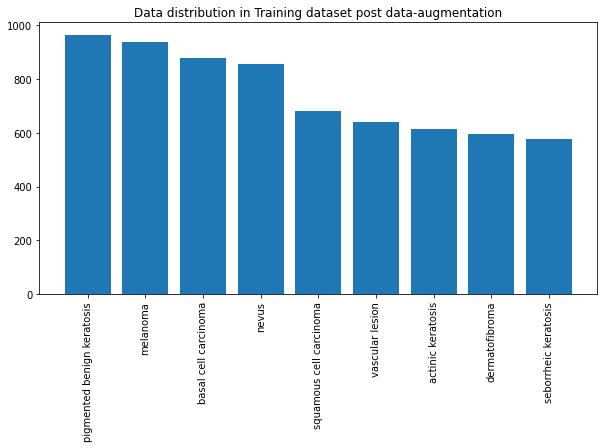

In [ ]:
plt.figure(figsize=(10,5))
plt.bar(x=new_df['Label'].value_counts().index, height=new_df['Label'].value_counts().values)
plt.xticks(rotation='vertical')
plt.title('Data distribution in Training dataset post data-augmentation')
plt.show()

So, now we have added 500 images to all the classes to maintain some class balance.

### 6. Model building:3 

Now let's train the model on the data created using Augmentor.

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### 6.1 Creating the training dataset

In [ ]:
data_dir_train= "gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train"    #"path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training", ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### 6.2 Creating the validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation", ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### 6.3 Creating the Model-3

In [ ]:
num_classes = 9

model3 = Sequential([
layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
layers.Conv2D(16, kernel_size=(3,3), padding='same', activation='relu'),
layers.MaxPooling2D(),
layers.Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'),
layers.MaxPooling2D(),
layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'),
layers.MaxPooling2D(),
layers.Flatten(),
layers.Dense(128, activation='relu'),
layers.Dense(num_classes, activation='softmax')
])

#### 6.4 Compiling the Model-3

In [ ]:
model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### 6.5 Training the Model-3

In [ ]:
epochs = 30

history = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 51s 94ms/step - loss: 2.0689 - accuracy: 0.2318 - val_loss: 1.6135 - val_accuracy: 0.3504
Epoch 2/30
169/169 [==============================] - 7s 40ms/step - loss: 1.4223 - accuracy: 0.4668 - val_loss: 1.2584 - val_accuracy: 0.5405
Epoch 3/30
169/169 [==============================] - 7s 40ms/step - loss: 1.1621 - accuracy: 0.5697 - val_loss: 1.1787 - val_accuracy: 0.5679
Epoch 4/30
169/169 [==============================] - 7s 40ms/step - loss: 0.9930 - accuracy: 0.6367 - val_loss: 0.9852 - val_accuracy: 0.6414
Epoch 5/30
169/169 [==============================] - 7s 40ms/step - loss: 0.7573 - accuracy: 0.7252 - val_loss: 1.0229 - val_accuracy: 0.6362
Epoch 6/30
169/169 [==============================] - 7s 40ms/step - loss: 0.6420 - accuracy: 0.7690 - val_loss: 0.9073 - val_accuracy: 0.6719
Epoch 7/30
169/169 [==============================] - 7s 40ms/step - loss: 0.5326 - accuracy: 0.8045 - val_loss: 0.7994 - val_accuracy: 0.723

#### 6.6 Visualizing training results of Model-3

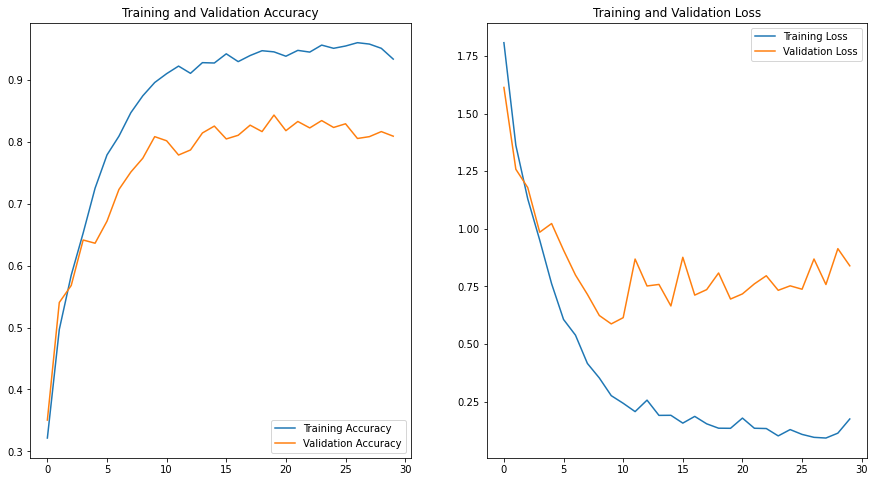

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

From the above, we note that:
1. We have been able to reduce the overfitting as well as underfitting (in comparision with Model 1 and 2) by balancing the dataset, with the help of class rebalancing.
2. It is apparent from the above two plots that increasing the no. of Epoch from 20 to 30 does not help as both training and validation Accuracies are getting flattened out after 20 Epochs. In fact validation loss is rising slightly after 20 epoch, which indicate rise in Variance. Hence it is not recommended to use more than 20 epoches for training.
3. Still there is scope for reduction in overfitting. We can further apply the methods like `Dropout`, `Regularization`, etc. to tackle the same.
4. We can even generate the augmented images such that we get exact balance among different classes and may get further improvement in the Accuracy of the CNN model.

------------------------------------------------------------------------------------------------------------------